### Import The Basic Required Packages

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from laplace_hdc_helper import load_dataset, filter_dataset, plot_images, plot_weights
from laplace_hdc_encoder import hdc_encoder
from laplace_hdc_classifier import train_hdc_classifier, test_hdc_classifier
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Check if Cuda is Available

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device:\t{device}")

Using device:	cuda:0


### Some Hyperparameters

In [3]:
hyperdim = 10000 
batch_size = 100
num_train = 60000
num_test = 10000
num_colors = 256
data_folder = '../../' # Change this according to the location of MNIST/Fashion MNIST dataset
selected_labels = [0,1,2,3,4,5,6,7,8,9]
num_classes = len(selected_labels)
use_conv_features = False
use_xor_zero_encoding = False

## Encoding

In [4]:
# Load data

train_data, test_data, class_names = load_dataset(
    "MNIST", # Use "FashionMNIST" for Fashion MNIST data set
    selected_labels,
    data_folder, 
    num_train, 
    num_test
)

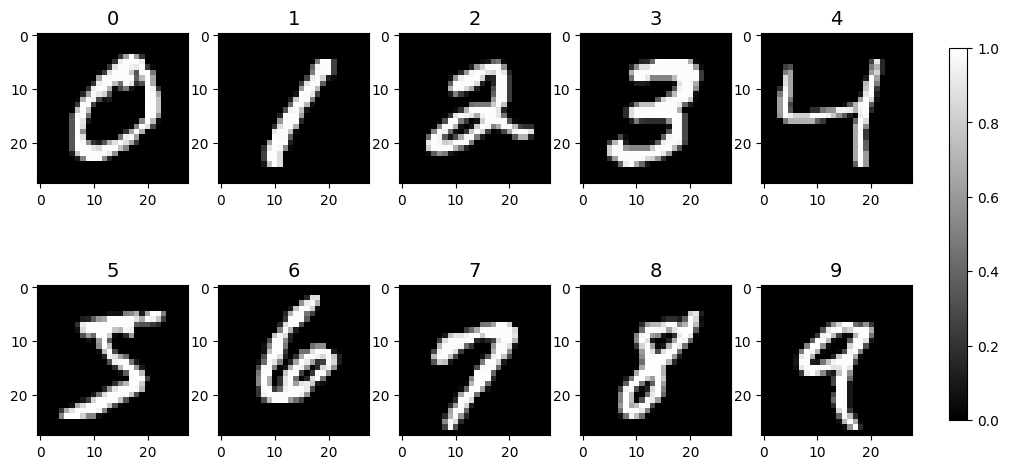

In [5]:
# Visualize sample data from each class
example_images = []
for i in range(10):
    j = 0
    while train_data[j][1] != i:
        j = j + 1
    example_images.append(train_data[j][0])

plot_images('fashion_examples.eps',example_images,class_names,vmin=0,vmax=1)

### Kernel Matrix Construction

In [6]:
# Determining Lambda from random 1000 samples

X,  _ = next(iter(DataLoader(train_data, batch_size=1000, shuffle=True)))
X = X.reshape(X.shape[0],-1)

D = torch.sum(torch.abs(X.unsqueeze(0)-X.unsqueeze(1)),dim=2)
a = torch.median(D.flatten())
lmd = 3/a
print(f"lambda = {lmd}")

# Define the local kernel
x = np.linspace(0, 1, num=num_colors).reshape(-1, 1)
f = lambda X: 1 - lmd*X
kernel = f(np.abs(x - x.T))

lambda = 0.02322334051132202


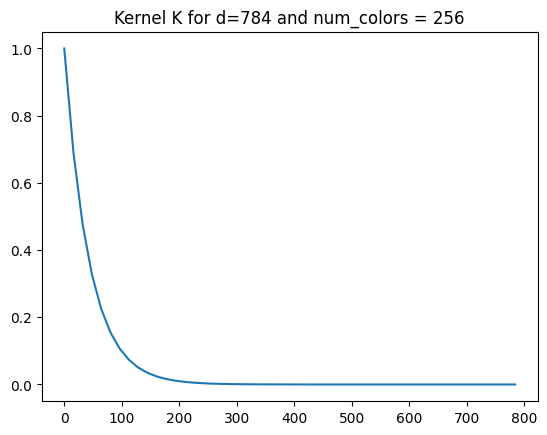

In [7]:
# Visualize the global kernel

d = train_data[0][0].squeeze().numel()
S = lambda v: np.exp(-lmd*v)
v = np.linspace(0, d)
plt.plot(v, S(v))
plt.title(f"Kernel K for d={d} and num_colors = {num_colors}")
plt.show()

In [8]:
encoder_modes = ['shift_1d', 'shift_2d', 'block_diag_shift_1d', 'block_diag_shift_2d'] # all options
encoder_mode = 'shift_1d'
# print(f"encoder mode: {encoder_mode}")

In [9]:
encoder = hdc_encoder(d, hyperdim, kernel, encoder_mode)
print(f"mode: {encoder_mode}\nHyperdimension: {encoder.hyperdim}")

mode: shift_1d
Hyperdimension: 10000


In [10]:
# Dataloader for the encoder

batch_size = 512
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# Encode the data

t0 = time.time()
train_hdc = encoder.encode(train_loader)
t1 = time.time()

print(f"train encoding time: {t1 -t0}")

t0 = time.time()
test_hdc = encoder.encode(test_loader)
t1 = time.time()

print(f"test encoding time: {t1 -t0}")

train encoding time: 87.78941679000854


## Classification

In [ ]:
# Dataloader for the classifier

batch_size = 256
train_loader_hdc = DataLoader(
    train_hdc,
    batch_size=batch_size,
    shuffle=True,
)

test_loader_hdc = DataLoader(
    test_hdc,
    batch_size=batch_size,
    shuffle=True,
)

In [ ]:
modes = ['float_sgd', 'binary_sgd', 'float_majority', 'binary_majority'] # all options
mode="float_sgd"
epochs=3
model = train_hdc_classifier(train_loader_hdc, num_classes, mode=mode, epochs=epochs)
accuracy = test_hdc_classifier(model, test_loader_hdc)
print(f"mode: {mode} \ntest accuracy: {accuracy}")